In [3]:
# Python processing for edf files
import fabio
from pathlib import Path
import matplotlib.pyplot as plt


In [4]:
path = Path("C:/Users/hduva/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents/Group Publishing/Heilman ZnPc")
edf_files = list(path.glob("**/*.edf"))
red_files = list(path.glob("**/*.csv"))
display(red_files)
edf_files

[WindowsPath('C:/Users/hduva/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents/Group Publishing/Heilman ZnPc/XuessGiwaxs.csv')]

[WindowsPath('C:/Users/hduva/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents/Group Publishing/Heilman ZnPc/ZnPc Xuess GIWAXS.edf'),
 WindowsPath('C:/Users/hduva/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents/Group Publishing/Heilman ZnPc/ZnPC_Xuess GIWAXS 1.edf')]

In [5]:
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.patches import Wedge

data = fabio.open(edf_files[1]).data[:984, :]

vmin, vmax = np.quantile(data, [0.1, 0.996])
cmp = plt.get_cmap('terrain')
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# convert pixel to inverse nm
pix_h = 0.075 # cm
pix_v = 0.075 # cm
det_distance = 72 #cm
lam = 1.54209 # Angstrom

center = (584, 983)

def get_x(i):
    return (i - center[0]) * pix_h

def get_y(j):
    return (center[1] - j) * pix_v

def get_qz(j):
    return 4 * np.pi / lam * np.sin(np.arctan(get_y(j) / det_distance / 2))

def get_qxy(i):
    return 4 * np.pi / lam * np.sin(np.arctan(get_x(i) / det_distance / 2))

print(vmin, vmax)

-0.00445199990645051 43.03109513854816


C:\Users\hduva\AppData\Local\Temp\ipykernel_7504\3192793201.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{get_qxy(x):.2f}" for x in ax.get_xticks()])
C:\Users\hduva\AppData\Local\Temp\ipykernel_7504\3192793201.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{get_qz(y):.2f}" for y in ax.get_yticks()])


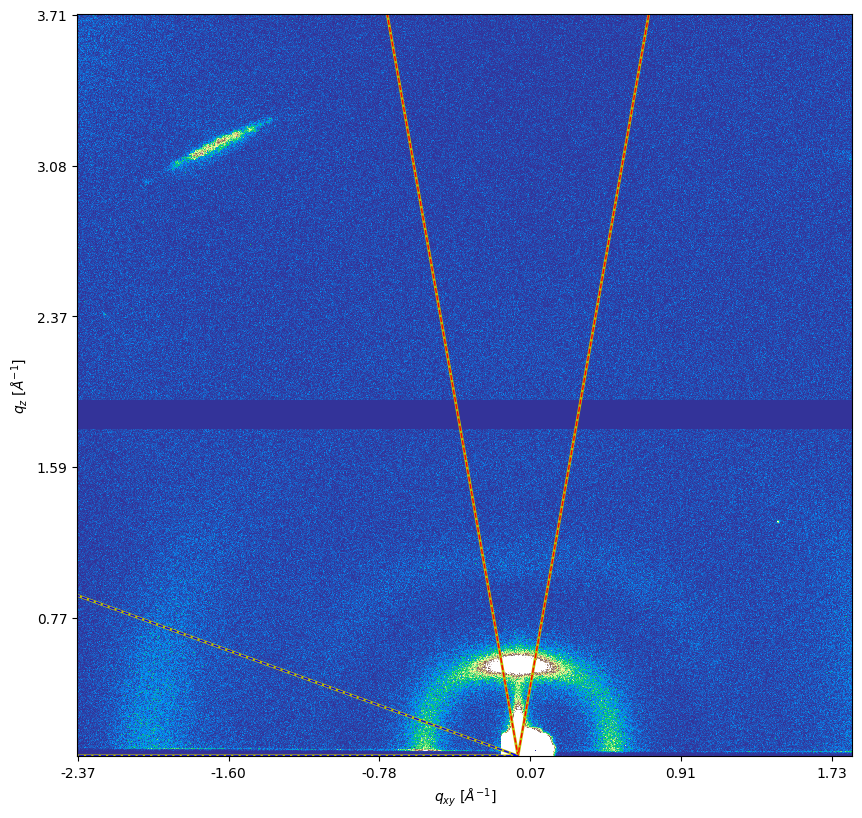

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(data, cmap=cmp, norm=norm, interpolation="none")
# add a wedge from 100 to 80 degrees
ax.add_patch(Wedge((584, 983), 1000, -100, -80, edgecolor='y', linewidth=2, fill=False))
ax.add_patch(Wedge((584, 983), 1000, -100, -80, edgecolor='r', linewidth=1, fill=False, linestyle='--'))
# add a wedge from 80 to 60 degrees
ax.add_patch(Wedge((584, 983), 1000, -180, -160, edgecolor='y', linewidth=2, fill=False))
ax.add_patch(Wedge((584, 983), 1000, -180, -160, edgecolor='b', linewidth=1, fill=False, linestyle='--'))

# determin the q map for each axis
ax.set_xticklabels([f"{get_qxy(x):.2f}" for x in ax.get_xticks()])
ax.set_yticklabels([f"{get_qz(y):.2f}" for y in ax.get_yticks()])



ax.set_xlabel(r"$q_{xy}$ $[Å^{-1}]$")
ax.set_ylabel(r"$q_{z}$ $[Å^{-1}]$")


# cbar = plt.colorbar(img, ax=ax)
# cbar.set_label("Intensity (a.u.)")
# cbar.set_label("Intensity (a.u.)")
fig.savefig(path/"Giwaxs_Scan.svg", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
from scipy.optimize import curve_fit
import scipy.signal as signal
from ipywidgets import interact

def gaussian(x, A, x0, fwhm):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return A * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-np.square(x - x0)/(2 * sigma**2))

def lorentzian(x, A, x0, fwhm):
    return (A / np.pi) * (fwhm / 2) / ((x - x0)**2 + (fwhm / 2)**2)

def voigt(x, A, x0, sigma, alpha):
    return (1-alpha)*gaussian(x, A, x0, sigma) + alpha*lorentzian(x, A, x0, sigma)

def voigt_bg(x, A, x0, sigma, alpha, B, w):
    return voigt(x, A, x0, sigma, alpha) + B * np.exp(-(1/w) * x)

peaks, pars = signal.find_peaks(reduced["$I_z$"], prominence=5)
fig, ax = plt.subplots()
ax.plot(reduced["$q_z$"], reduced["$I_z$"])
ax.plot(reduced["$q_z$"][peaks], reduced["$I_z$"][peaks], "x")
ax.set_xlabel(r"$q_z$ $[Å^{-1}]$")
ax.set_yscale("log")

p0 = [
    pars["prominences"][0],
    reduced["$q_z$"][peaks[0]],
    0.01,
    0.5,
    1,
    10
]

bounds = (
    [0, .4, 0, 0, 0, 0],
    [np.inf, .6, np.inf, np.inf, 3, 10]
)

reduced = reduced.dropna()
fit = reduced.iloc[pars["left_bases"][0]:3*pars["left_bases"][0]]
ax.plot(fit["$q_z$"], fit["$I_z$"], label="Voigt")
sigma = np.sqrt(fit["$I_z$"])
# Adjust the dimensions of the bounds array to match the number of parameters in p0

popt, pcov = curve_fit(voigt_bg, fit["$q_z$"], fit["$I_z$"], p0=p0, bounds=bounds, sigma=sigma)
ax.plot(fit["$q_z$"], voigt_bg(fit["$q_z$"], *popt), label="Fit")
ax.plot(fit["$q_z$"], fit["$I_z$"])

err = np.sqrt(np.diag(pcov))
name = ["A", "x0", "sigma", "alpha", "B", "w"]
for i, (param, error) in enumerate(zip(popt, err)):
    print(f"{name[i]} {param:.2f} ± {2*error:.3f}")


NameError: name 'reduced' is not defined

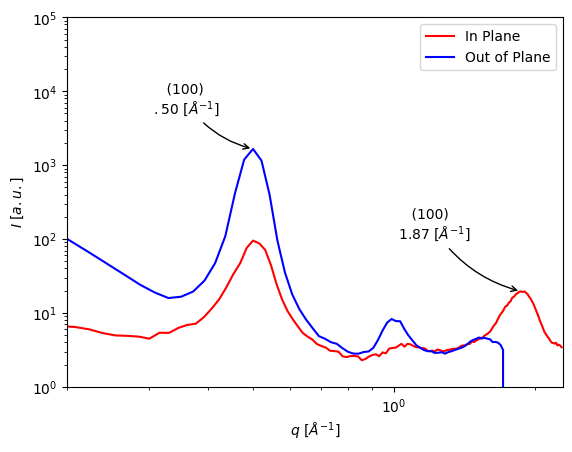

In [188]:
import pandas as pd


reduced = pd.read_csv(red_files[0])
reduced.columns = [r"$I_z$", r"$q_z$", r"$I_{xy}$", r"$q_{xy}$"]

# mask out of plane data after 1.5
mask = reduced[r"$q_z$"] < 1.8
reduced["$I_z$"] = reduced[r"$I_z$"].mask(~mask)
reduced["$q_z$"] = reduced[r"$q_z$"].mask(~mask)

fig, ax = plt.subplots()
ax.plot(reduced[r"$q_{xy}$"], reduced[r"$I_{xy}$"], label="In Plane", color="red")
ax.plot(reduced[r"$q_z$"], reduced[r"$I_z$"], label="Out of Plane", color="blue")

peaks, _ = signal.find_peaks(reduced["$I_z$"], prominence=5)
# annotate the first peak with an arow
ax.annotate("    (100)\n" + r" $.50$ $[Å^{-1}]$", 
            xy = (reduced["$q_z$"][peaks[0]], reduced["$I_z$"][peaks[0]]), 
            xytext=(.3, 5e3), 
            arrowprops=dict(
                arrowstyle="->", 
                facecolor="C5",
                connectionstyle="arc3,rad=.2"))

peaks, _ = signal.find_peaks(reduced[r"$I_{xy}$"], prominence=5)
at = reduced[r"$q_{xy}$"][peaks[-1]]
ax.annotate("    (100)\n" + r" $1.87$ $[Å^{-1}]$", 
            xy = (reduced[r"$q_{xy}$"][peaks[-1]], reduced[r"$I_{xy}$"][peaks[-1]]), 
            xytext=(1, 100), 
            arrowprops=dict(
                arrowstyle="->", 
                facecolor="C5",
                connectionstyle="arc3,rad=.2"))


ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(2e-1, 2.3)
ax.set_ylim(1, 1e5)

ax.legend()

ax.set_xlabel(r"$q$ $[Å^{-1}]$")
ax.set_ylabel(r"$I$ $[a.u.]$")

fig.savefig(path/"Giwaxs_Reduced_Fit.svg")

In [12]:
coords = pd.read_csv(path/"ZnPcCoords.sdf", sep='\s+', skiprows=4, nrows=57, usecols=[0, 1, 2, 3], names=["x", "y", "z", "atom"])
# shift the coordinates such the the Zn atom is at the origin
coords["x"] -= coords["x"].iloc[0]
coords["y"] -= coords["y"].iloc[0]
coords["z"] -= coords["z"].iloc[0]

coords

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hduva\AppData\Local\Temp\ipykernel_28248\994584190.py:1: SyntaxWarning: invalid escape sequence '\s'
  coords = pd.read_csv(path/"ZnPcCoords.sdf", sep='\s+', skiprows=4, nrows=57, usecols=[0, 1, 2, 3], names=["x", "y", "z", "atom"])


,x,y,z,atom
0,0.0000,0.0000,0.0,Zn
1,-1.0000,0.0000,0.0,N
2,-1.5935,-1.6253,0.0,N
3,-1.5160,1.7544,0.0,N
4,1.3219,0.0000,0.0,N
5,1.8637,-1.6770,0.0,N
6,1.8637,1.7801,0.0,N
7,0.1609,-1.1610,0.0,N
8,0.1609,1.1609,0.0,N
9,-2.7028,-0.4903,0.0,C


10.757650170924876


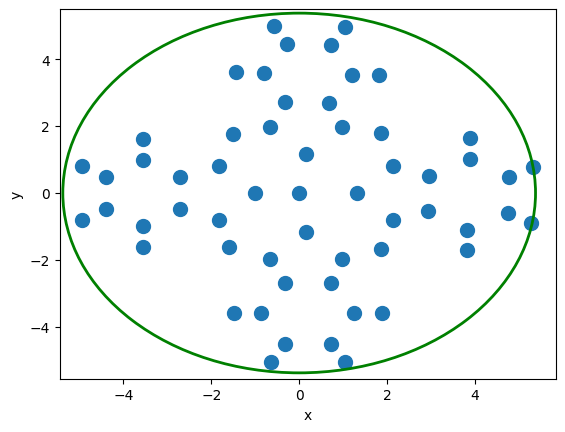

In [189]:
fig, ax = plt.subplots()
coords.plot.scatter("x", "y", s=100, colorbar=False, ax=ax)
# Find the max distance from the Zn atom
coords["distance"] = np.sqrt((coords["x"] - coords["x"].iloc[0])**2 + (coords["y"] - coords["y"].iloc[0])**2)
print(coords["distance"].max()*2)
# add a circle with the max distance
ax.add_patch(plt.Circle((coords["x"].iloc[0], coords["y"].iloc[0]), coords["distance"].max(), edgecolor='g', linewidth=2, fill=False))

In [191]:
rad = coords["distance"].max()
size = 2*np.pi/.5
size

12.566370614359172